## Prediktiv Analyse

I denne prediktive analysen har vi produsert ulike visualiseringer som viser prediktive data for MW produksjon et år frem i tid (2022). 

Linjediagram
- De første visualiseringene er linjediagrammer som viser hvordan scikit-learn funksjonen har forutsett fremtidige MW verdier for 2022 både for det originale datasettet (df_germany) og det komplette datasettet uten mangler og duplikater (df). Denne visualiseringstypen er fin til å vise trender/endringer over tid, og det er dermed enkelt og oppdage mulige sesongvariasjoner, svingninger og andre mønstre i datasettet. I denne analysen ser vi tydelig hvordan MW produksjonen varierer fra måned til måned. 

Histogram
- Histogrammet vi har brukt er et søylediagram som visualiserer forskjellen i predikert MW produksjon mellom df_germany og df. Denne visualiseringstypen er godt egnet for å vise fordelingen av forskjeller og gir innsikt i hvordan prediksjonsfeilene varierer. I visualiseringen ser man at flesteparten av forskjellene er små og negative.

Scatterplot
- I denne oppgaven har vi brukt scatterplots som visualiserer sammenhengen mellom faktisk produsert MW og predikert MW for df_germany og df. Scatterplots visualiserer sammenhengen mellom to kontinuerlige variabler. I dette tilfellet kan vi se hvor nært predikasjonene ligger mot den ideelle linjen. Den ideelle linjen visualiseres som en rødstriplet linje, og representerer hvor punktene ville ha ligget dersom modellen fant helt perfekte verdier. I stedet ser vi punkter som ligger spredt og lavt på y-aksen, fordi modellen undervurderer den fremtidige MW produksjonen. R^2 og RMSE er lavt for begge datasettene som forteller oss at ca 11,4% av variasjonen i den faktiske MW produksjonen blir forklart. RMSE på 2866 MW forteller at modellen bommer med ca. 2866 MW på hver predikasjon. 


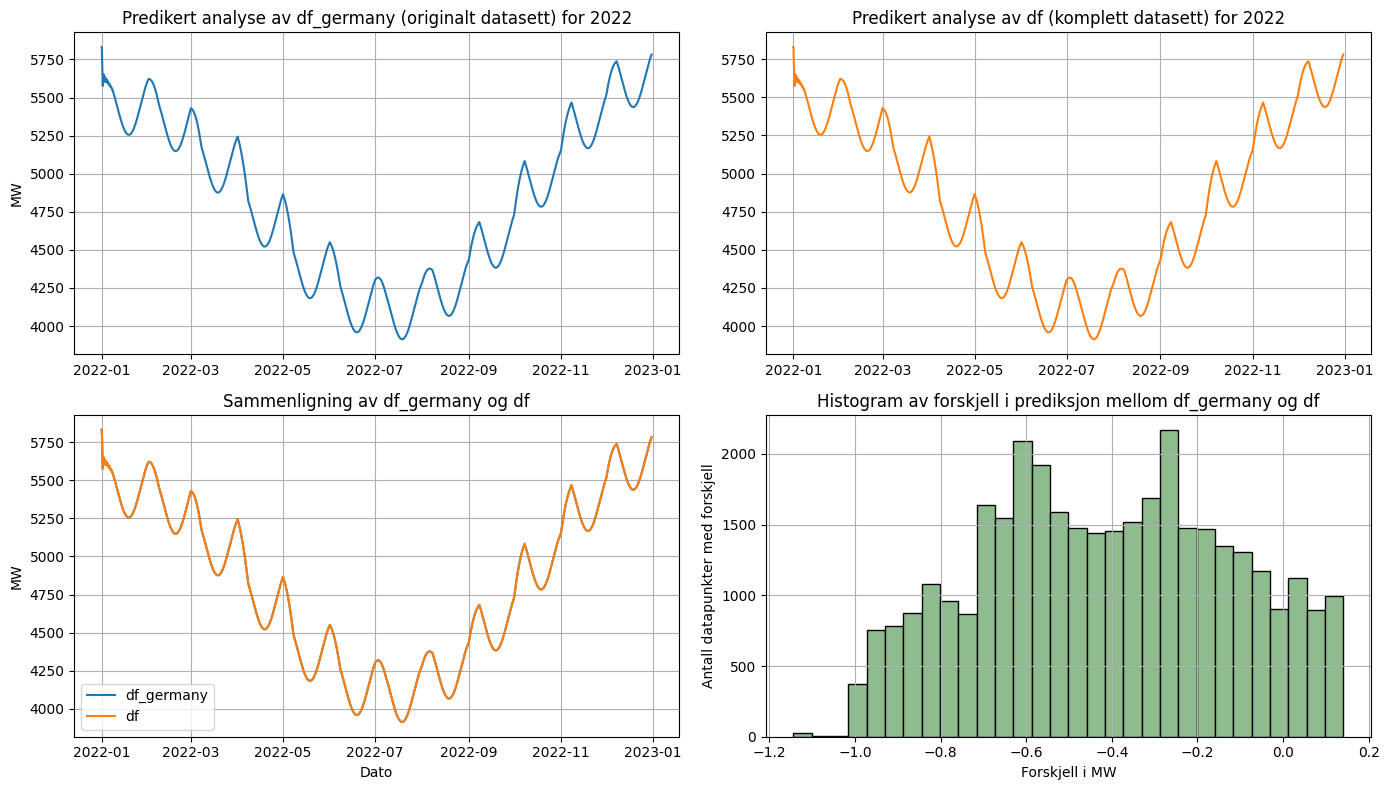

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import os
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

# Orginalt datasett (df_germany)
pathGermany = kagglehub.dataset_download("l3llff/wind-power")
df_germany = pd.read_csv(f"{pathGermany}/data.csv")
df_germany["datetime"] = pd.to_datetime(df_germany["dt"])

df_germany["hour"] = df_germany["datetime"].dt.hour
df_germany["day"] = df_germany["datetime"].dt.day
df_germany["week"] = df_germany["datetime"].dt.isocalendar().week
df_germany["month"] = df_germany["datetime"].dt.month
df_germany["year"] = df_germany["datetime"].dt.year

# Datasett etter behandling (df)
csv_filsti = os.path.join("..", "data", "komplett_data_med_utfylte_mengder.csv")
df = pd.read_csv(csv_filsti)
df['datetime'] = pd.to_datetime(df['datetime'])

df["hour"] = df["datetime"].dt.hour
df["day"] = df["datetime"].dt.day
df["week"] = df["datetime"].dt.isocalendar().week
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year

# Funksjon for å lage lagrede funksjoner
def lag_funksjoner(df, start_tid):
    df = df.copy()
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["day_sin"] = np.sin(2 * np.pi * df["day"] / 31)
    df["day_cos"] = np.cos(2 * np.pi * df["day"] / 31)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["minutes_since_start"] = (df["datetime"] - start_tid).dt.total_seconds() / 60
    return df[["hour_sin", "hour_cos", "day_sin", "day_cos", "month_sin", "month_cos", "minutes_since_start"]]

start_tid = min(df["datetime"].min(), df_germany["datetime"].min())

# Lager lagrede funksjoner for df_germany og df
X_germany = lag_funksjoner(df_germany, start_tid)
y_germany = df_germany["MW"]
model_germany = LinearRegression().fit(X_germany, y_germany)

X_complete = lag_funksjoner(df, start_tid)
y_complete = df["MW"]
model_complete = LinearRegression().fit(X_complete, y_complete)

# Prediksjon for fremtidige datoer i 2022
future_dates = pd.date_range("2022-01-01", "2022-12-31 23:45", freq="15min")
future_df = pd.DataFrame({"datetime": future_dates})
future_df["hour"] = future_df["datetime"].dt.hour
future_df["day"] = future_df["datetime"].dt.day
future_df["month"] = future_df["datetime"].dt.month

# Lager lagrede funksjoner for fremtidige datoer
X_future = lag_funksjoner(future_df, start_tid)
future_df["pred_germany"] = model_germany.predict(X_future)
future_df["pred_complete"] = model_complete.predict(X_future)

# Glatter ut prediksjonene og gjørde mer lesbare
future_df["pred_germany_smooth"] = future_df["pred_germany"].rolling(window=672, min_periods=1).mean()
future_df["pred_complete_smooth"] = future_df["pred_complete"].rolling(window=672, min_periods=1).mean()

# Plotting av prediktiv analyse
plot_df = future_df[(future_df["datetime"] >= "2022-01-01") & (future_df["datetime"] <= "2022-12-31")].copy()
plot_df["forskjell"] = plot_df["pred_complete_smooth"] - plot_df["pred_germany_smooth"]

# Lager 2x2 figur
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=False)

# Øverst til venstre: df_germany 
axes[0, 0].plot(plot_df["datetime"], plot_df["pred_germany_smooth"], color="tab:blue")
axes[0, 0].set_title("Predikert analyse av df_germany (originalt datasett) for 2022")
axes[0, 0].set_ylabel("MW")
axes[0, 0].grid(True)

# Øverst til høyre: df 
axes[0, 1].plot(plot_df["datetime"], plot_df["pred_complete_smooth"], color="tab:orange")
axes[0, 1].set_title("Predikert analyse av df (komplett datasett) for 2022")
axes[0, 1].grid(True)

# Nederst til venstre: Sammenligning av df_germany og df
axes[1, 0].plot(plot_df["datetime"], plot_df["pred_germany_smooth"], label="df_germany", color="tab:blue")
axes[1, 0].plot(plot_df["datetime"], plot_df["pred_complete_smooth"], label="df", color="tab:orange")
axes[1, 0].set_title("Sammenligning av df_germany og df")
axes[1, 0].set_xlabel("Dato")
axes[1, 0].set_ylabel("MW")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Nederst til høyre: Histogram av forskjell mellom df_germany og df
axes[1, 1].hist(plot_df["forskjell"], bins=30, color="darkseagreen", edgecolor="black")
axes[1, 1].set_title("Histogram av forskjell i prediksjon mellom df_germany og df")
axes[1, 1].set_xlabel("Forskjell i MW")
axes[1, 1].set_ylabel("Antall datapunkter med forskjell")
axes[1, 1].grid(True)

# Viser figuren
plt.tight_layout()
plt.show()

### Påvirkning av manglende data
Ved å renske datasettet df_germany og produsere et komplett datasett (df), ser vi påvirkningen mangler i datasett har. Dette visualiseres i grafene over.

Mangler i datasettet påvirker tolkningen vi får av et datasett gjennom ulike faktorer. Hvis viktige perioder/data mangler fra datasettet kan det gi feilaktige intrykk av trender, sesongvariasjoner og andre mønstre. Analyser av data vil ikke bli konkrete når alle verdier er med på å regne ut verdier som f.eks. gjennomsnitt, standardavvik, median osv. en annen faktor er at prediktive modeller kan gi dårlige prediksjoner ved at viktige data mangler fra datasettet. 

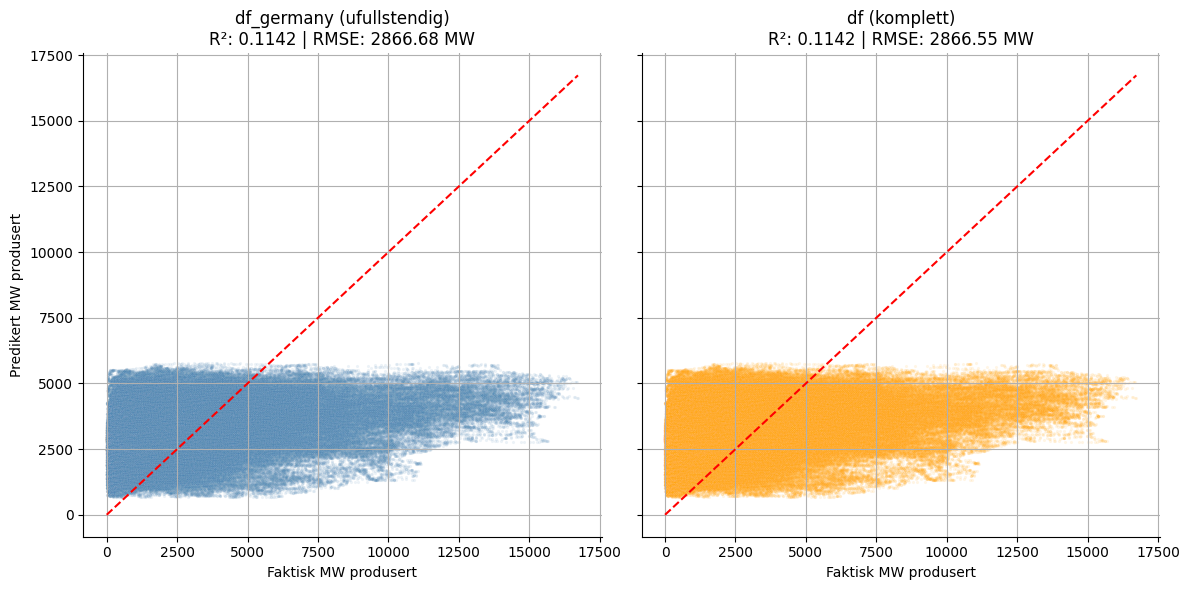

In [26]:
# Sammenligning av prediksjonene for df og df_germany
y_pred_germany = model_germany.predict(X_germany)
y_pred_df = model_complete.predict(X_complete)

# Lag samlet DataFrame for Seaborn
df_plot = pd.DataFrame({
    "Faktisk MW produsert": np.concatenate([y_germany, y_complete]),
    "Predikert MW produsert": np.concatenate([y_pred_germany, y_pred_df]),
    "Datasett": ["df_germany (ufullstendig)"] * len(y_germany) + ["df (komplett)"] * len(y_complete)
})

# R^2 og RMSE for df og df_germany
r2_df = r2_score(y_complete, y_pred_df)
rmse_df = np.sqrt(mean_squared_error(y_complete, y_pred_df))

r2_germany = r2_score(y_germany, y_pred_germany)
rmse_germany = np.sqrt(mean_squared_error(y_germany, y_pred_germany))

# Mapping for tittel-tekst med metrikker
tittel_map = {
    "df (komplett)": f"R²: {r2_df:.4f} | RMSE: {rmse_df:.2f} MW",
    "df_germany (ufullstendig)": f"R²: {r2_germany:.4f} | RMSE: {rmse_germany:.2f} MW"
}

fargemap = {
    "df (komplett)": "orange",
    "df_germany (ufullstendig)": "steelblue"
}

# Tegn med FacetGrid
g = sns.FacetGrid(df_plot, col="Datasett", hue="Datasett", palette=fargemap,
                  hue_order=["df_germany (ufullstendig)", "df (komplett)"],
                  col_order=["df_germany (ufullstendig)", "df (komplett)"],
                  height=6, aspect=1)

g.map_dataframe(sns.scatterplot, x="Faktisk MW produsert", y="Predikert MW produsert", alpha=0.1, s=5)

# Legg til prediksjonslinje og titler
for ax, dataset in zip(g.axes.flat, ["df_germany (ufullstendig)", "df (komplett)"]):
    min_val = df_plot["Faktisk MW produsert"].min()
    max_val = df_plot["Faktisk MW produsert"].max()
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')
    ax.set_title(f"{dataset}\n{tittel_map[dataset]}")
    ax.grid(True)

plt.tight_layout()
plt.show()

### Evaluering:

Linjediagrammene og histogrammet visualiserer konkret trender over tid i de predikerte dataene, spesielt for å sammenlige forskjellen mellom de to datasettene. Der viser histogrammet hvor stor forskjellen er, og hvordan de er fordelt. 

Scatterplottene formidlet best nøyaktigheten av modellen. Den visualiserer tydelig avviket mellom den faktiske produksjonen og den predikerte, ved å se på hvor punktene ligger i forhold til den røde striplete linjen. 